# StackGP.rmse
```{python}
StackGP.rmse(model,inputData,response)
```

`rmse` is a StackGP function that computes the root mean squared error for a GP model. 

The function expects 3 arguments: _model_, _inputData_, and _response_

The arguments are described below: 

* **model**: A StackGP model. 
* **inputData**: A numpy array containing the input data used to evaluate the model.
* **response**: The ground truth response to compare the model's response to.

---

First we need to load in the necessary packages

In [1]:
import StackGP as sgp
import numpy as np

## Overview

### Computing RMSE for a random model

Here we generate a random model with up to 4 variables, the default operator set, the default constant set, and a maxSize of 10. 

In [2]:
randomModel=sgp.generateRandomModel(4, sgp.defaultOps(), sgp.defaultConst(), 10)

We can display the random model below

In [3]:
sgp.printGPModel(randomModel)

x0**2 + 12.886958230384

Now we generate a random input dataset and a ground truth response vector. 

In [4]:
inputData = np.random.rand(4, 100) 
response = np.sin(inputData[0]) + np.cos(inputData[1]) + inputData[2]**2 - inputData[3]**3

Now we can compute the RMSE between the model's response and the ground truth response. 

In [5]:
sgp.rmse(randomModel, inputData, response)

11.885763870944336

---
---

## Examples

This section provides some interesting examples to demonstrate how `rmse` can be used. 

---

### Checking error of best evolved model
Likely, we are interested in determining the quality of the best model evolved on a test set. 

Lets start by generating a training and test set with 4 features. 

In [22]:
trainInputData = np.random.rand(4, 100)
trainResponse = 5*trainInputData[0] + 2*trainInputData[1] + trainInputData[2]**2
testInputData = np.random.rand(4, 100)
testResponse = 5*testInputData[0] + 2*testInputData[1] + testInputData[2]**2

Now lets evolve a model population using the training data. 

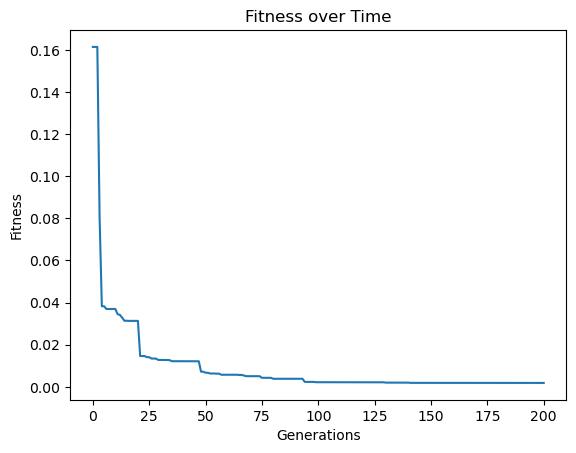

In [23]:
models=sgp.evolve(trainInputData, trainResponse, tracking=True, generations=200, elitismRate=10, tourneySize=30)

Now lets pick the best model evolved from the population. 

In [26]:
bestModel = models[0]
sgp.printGPModel(bestModel)

4.05907675740214 + 8.93984953470558*(x0*(x2**2 + 2.22349023607508) + x1 - 1.87464002672662)/(exp(x2**2) + 3.10786161984353)

Now lets evaluate the RMSE of the best model on the test set.

In [27]:
sgp.rmse(bestModel, testInputData, testResponse)

0.06950955185265639

We can compare that to the RMSE on the training set to see if we were overfitting the training or performing similarly on both sets. 

In [30]:
sgp.rmse(bestModel, trainInputData, trainResponse)

0.06994713153756658

### Using RMSE as a Fitness Objective

While it has been shown to be less effective in training than correlation, for benchmarking or other purposes, it may be beneficial to use RMSE as a training objective. 

We will use a randomly generated model to generate the response. So we start with generating a random model. 

In [36]:
randomModel=sgp.generateRandomModel(4, sgp.defaultOps(), sgp.defaultConst(), 20)
sgp.printGPModel(randomModel)

exp(x2)/sqrt(exp(-x2))

Now we can generate some data and use the above random model to generate the response from the random input data. 

In [37]:
inputData = np.random.rand(4, 100)
response = sgp.evaluateGPModel(randomModel, inputData)

Now we can evolve models to fit the generated training data. We will set rmse as the fitness objective rather than simplicity and correlation. 

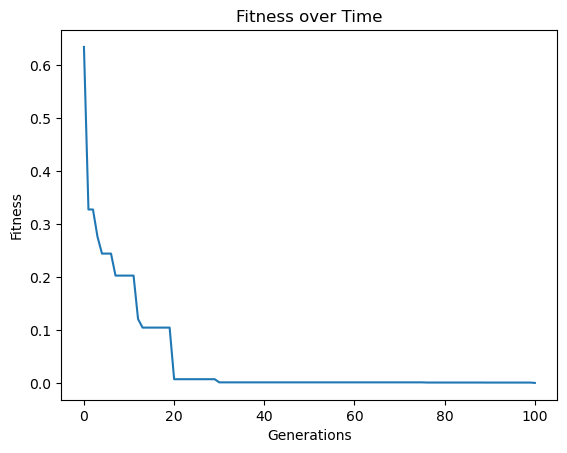

In [40]:
models = sgp.evolve(inputData,response, tracking=True, modelEvaluationMetrics=[sgp.rmse])

Now we can look at the best model generated. 

In [43]:
sgp.printGPModel(models[0])

0.999512900120274*exp(1.50038757722228*x2) + 0.000571183205158241

Now we can check how well it generalizes to test data. First we need to generate the test data. 

In [44]:
testInputData = np.random.rand(4, 100)
testResponse = sgp.evaluateGPModel(randomModel, testInputData)

Now we can compute the RMSE on the test data. 

In [45]:
sgp.rmse(models[0], testInputData, testResponse)

4.5955382363536954e-05

We can also visualize the quality of predictions on the test data. 

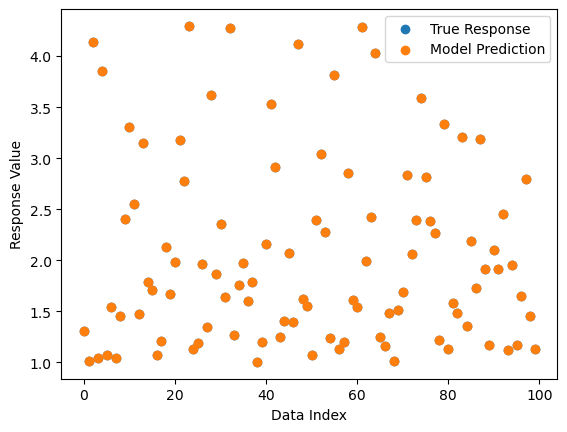

In [46]:
sgp.plotModelResponseComparison(models[0], testInputData, testResponse)

To make it easier to see how close the values are to the test values, we can visualize the residual plot. 

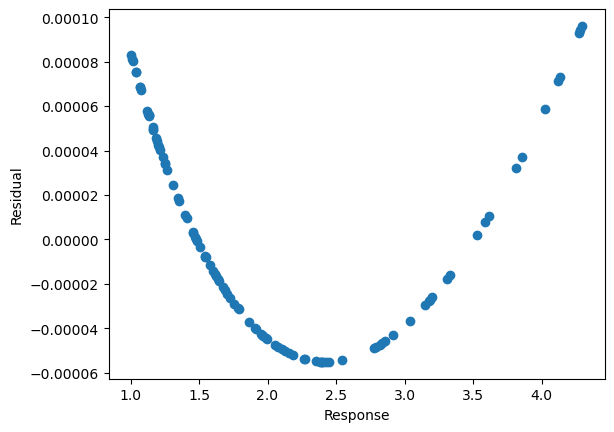

In [47]:
sgp.plotModelResiduals(models[0], testInputData, testResponse)

### Updating Embedded Objectives in Evolved Model

We may be interested in evolving a model population using one set of fitness objectives and then evaluating and storing another set of objectives after evolution. We can easily do this with the `setModelQuality` function. 

First we need to generate some models and data. 

In [49]:
inputData = np.random.rand(5, 100)
randomModel = sgp.generateRandomModel(5, sgp.defaultOps(), sgp.defaultConst(), 20)
response = sgp.evaluateGPModel(randomModel, inputData)
sgp.printGPModel(randomModel)

x1**2/x2 - x4

Now lets train a model using the standard search objectives. 

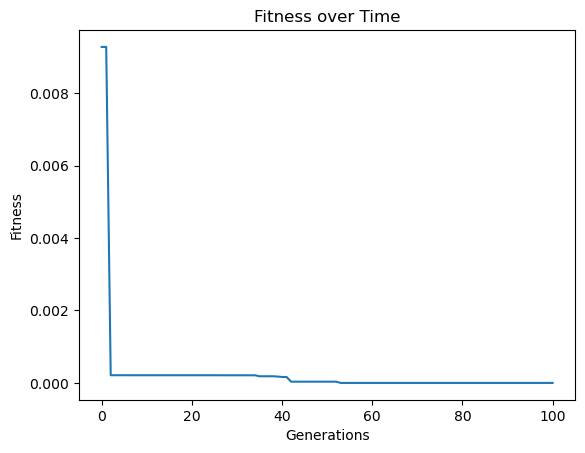

In [50]:
models = sgp.evolve(inputData, response, tracking=True)

Now we can generate a test set. 

In [51]:
testInputData = np.random.rand(5, 100)
testResponse = sgp.evaluateGPModel(randomModel, testInputData)

Now we can upate the model embedded model quality objectives to include RMSE with respect to the test set. 

In [52]:
for model in models: 
    sgp.setModelQuality(model, testInputData, testResponse, [sgp.fitness, sgp.stackGPModelComplexity, sgp.rmse])

Now we can look at the fitness vector of a model and we can see it contains 3 values ($1-r^2$, complexity, and RMSE).

In [57]:
display(sgp.printGPModel(models[0]))
print("Fitness vector: ", models[0][-1])

1.0*x1**2/x2 - 1.0*x4 + 3.89067216665765e-15

Fitness vector:  [0.0, 10, 6.365517961489426e-15]
